# DLC Live PyTorch Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dlclive import DLCLive, Processor
from dlclive.display import Display
import cv2
import numpy as np
from pathlib import Path
import time

Loading DLC 3.0.0rc4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Snapshot to ONNX model 

In [6]:
# In case you do not have a .onnx model exported, use this cell to export your DLC3.0 snapshot

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel
import torch
import onnxruntime as ort

device = "cuda" if torch.cuda.is_available() else "cpu"

root = Path("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy")
model_cfg = read_config_as_dict(root / "pytorch_config.yaml")
weights_path = root / "snapshot-200.pt"

model = PoseModel.build(model_cfg["model"])
weights = torch.load(weights_path, map_location=device)
model.load_state_dict(weights["model"])

dummy_input = torch.zeros((1, 3, 224, 224))

torch.onnx.export(
    model,
    dummy_input,
    "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/resnet.onnx",
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)

/tmp/ipykernel_34268/968774635.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_path, map_location=device)


In [13]:
# Load test frame
img = cv2.imread("/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy/img008.png")

### DLC Live with ONNX exported DLC 3.0 model

In [8]:
# Dikra
onnx_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    model_type="onnx",
    device="cuda",
    display=True,
)

# Anna
# onnx_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# onnx_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

onnx_pose = onnx_dlc_live.init_inference(frame=img)
onnx_pose

{'poses': tensor([[[[7.3832e+01, 2.0015e+02, 8.8095e-02],
           [6.9048e+01, 2.9947e+02, 2.2019e-01],
           [1.1621e+02, 3.4326e+02, 3.1128e-01],
           [1.1751e+02, 3.3694e+02, 5.3471e-01],
           [1.1515e+02, 3.2886e+02, 6.5886e-01],
           [1.3284e+02, 3.1905e+02, 3.0138e-01],
           [7.9400e+01, 2.1545e+02, 6.3844e-01],
           [5.0567e+01, 3.0373e+02, 2.5542e-01],
           [1.2382e+02, 2.5162e+02, 7.6581e-01],
           [1.3796e+02, 2.2743e+02, 6.9886e-01],
           [1.4197e+02, 2.0919e+02, 6.3363e-01],
           [1.6022e+02, 2.7524e+02, 6.3262e-01],
           [9.4027e+01, 2.5252e+02, 1.9836e-01],
           [1.4154e+02, 3.7739e+02, 8.7275e-01],
           [1.4946e+02, 3.6513e+02, 6.4267e-01],
           [2.7488e+01, 2.0230e+02, 8.3611e-01],
           [2.6656e+01, 3.4699e+02, 8.0565e-01],
           [3.1491e+01, 3.9521e+02, 8.7074e-01],
           [2.5922e+01, 1.5689e+02, 7.5119e-01],
           [3.0520e+01, 1.7030e+02, 8.1288e-01],
           

![Screenshot from 2024-08-20 14-29-53.png](./docs/assets/Screenshot%20from%202024-08-20%2014-36-00.png)

In [14]:
onnx_pose = onnx_dlc_live.get_pose(frame=img)
onnx_pose

{'poses': tensor([[[[3.6219e+02, 4.1237e+02, 5.0502e-01],
           [3.6271e+02, 3.9584e+02, 5.8567e-01],
           [3.5676e+02, 3.7446e+02, 7.0505e-01],
           [3.4043e+02, 3.5935e+02, 7.1149e-01],
           [3.3437e+02, 4.0497e+02, 6.5122e-01],
           [3.3772e+02, 4.0689e+02, 4.4919e-01],
           [2.0013e+02, 4.3547e+02, 5.2071e-01],
           [3.4130e+02, 4.3089e+02, 3.4862e-01],
           [2.1540e+02, 3.9427e+02, 7.8372e-01],
           [1.9974e+02, 3.7728e+02, 5.2794e-01],
           [1.8255e+02, 3.6741e+02, 6.4688e-01],
           [2.7519e+02, 3.3175e+02, 5.7645e-01],
           [3.5014e+02, 4.3089e+02, 4.1499e-01],
           [4.3459e+02, 3.1566e+02, 8.1675e-01],
           [4.2561e+02, 2.9912e+02, 8.8807e-01],
           [2.4359e+02, 5.0565e+02, 5.7659e-01],
           [3.5792e+02, 4.8275e+02, 3.0052e-01],
           [4.0234e+02, 4.1449e+02, 5.4220e-01],
           [1.7142e+02, 4.8666e+02, 4.5839e-01],
           [3.2110e+02, 5.1144e+02, 2.5084e-01],
           

In [15]:
onnx_dlc_live.display.destroy()

### DLC Live with snaptshot of DLC 3.0 model (.pt)

In [7]:
# Dikra
pytorch_dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    snapshot="snapshot-200.pt",
    device="cuda",
    model_type="pytorch",
    display=True,
)

# Anna
# pytorch_dlc_live = DLCLive(pytorch_cfg="/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train", processor=dlc_proc, snapshot='/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/Ventral_gait_model/train/snapshot-263.pt')
# pytorch_dlc_live = DLCLive("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/DLC_dev-single-animal_resnet_50_iteration-1_shuffle-1", processor=dlc_proc)
# img = cv2.imread("/Users/annastuckert/Documents/DLC_AI_Residency/DLC_AI2024/DeepLabCut-live/exported DLC model for dlc-live/img049.png")

pytorch_pose = pytorch_dlc_live.init_inference(frame=img)
pytorch_pose

/home/dikra/MyHub/Code/DLC24_Hub/DLC_AI2024/DeepLabCut-live/dlclive/dlclive.py:260: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_path, map_locati

{'poses': tensor([[[[4.6099e+02, 3.0565e+02, 2.2497e-01],
           [4.6334e+02, 2.9737e+02, 5.2393e-01],
           [4.7105e+02, 2.9226e+02, 5.7827e-01],
           [4.7816e+02, 2.9004e+02, 6.5970e-01],
           [5.7700e+02, 3.4287e+02, 6.7695e-01],
           [4.4610e+02, 3.3317e+02, 6.4596e-01],
           [5.3632e+02, 4.2195e+02, 5.4373e-01],
           [4.5563e+02, 3.5570e+02, 2.5123e-01],
           [5.5438e+02, 3.6476e+02, 6.2622e-01],
           [5.3584e+02, 3.6377e+02, 6.4735e-01],
           [5.1307e+02, 3.6640e+02, 6.0587e-01],
           [5.2159e+02, 2.9548e+02, 4.5409e-01],
           [4.8214e+02, 3.8471e+02, 2.4118e-01],
           [4.8334e+02, 2.1336e+02, 7.4011e-01],
           [4.5919e+02, 2.0870e+02, 6.2153e-01],
           [6.0561e+02, 4.7224e+02, 5.8598e-01],
           [5.9742e+02, 4.2868e+02, 4.8355e-01],
           [5.7910e+02, 4.2470e+02, 2.6089e-01],
           [4.6775e+02, 4.9880e+02, 8.5475e-01],
           [4.4069e+02, 4.2392e+02, 6.7025e-01],
           

In [8]:
pytorch_dlc_live.display.destroy()

![PyTorch model inference](./docs/assets/Screenshot%20from%202024-08-20%2014-29-53.png)

### Which is faster?

In [24]:
import glob
import os

root = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy"
test_images = glob.glob(os.path.normpath(root + "/*.png"))


def mean_time_inference(dlc_live, images):
    times = []
    for i, img_p in enumerate(images):
        img = cv2.imread(img_p)

        if i == 0:
            start = time.time()
            dlc_live.init_inference(img)
            end = time.time()
        else:
            start = time.time()
            dlc_live.get_pose(img)
            end = time.time()
        times.append(end - start)
    print(times)

    return np.mean(times), times

In [12]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    device="cuda",
    model_type="onnx",
    display=True,
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"TOTAL Inference of ONNX model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 0.10965681076049805 sec
ONNX inference took 1.3574702739715576 sec
ONNX inference took 0.0489506721496582 sec
ONNX inference took 0.05127286911010742 sec
ONNX inference took 0.04564523696899414 sec
ONNX inference took 0.045925140380859375 sec
ONNX inference took 0.04640650749206543 sec
ONNX inference took 0.04673171043395996 sec
ONNX inference took 0.04611396789550781 sec
ONNX inference took 0.04607415199279785 sec
ONNX inference took 0.04634737968444824 sec
ONNX inference took 0.04708504676818848 sec
ONNX inference took 0.04560351371765137 sec
ONNX inference took 0.04625558853149414 sec
ONNX inference took 0.0464634895324707 sec
ONNX inference took 0.04563474655151367 sec
ONNX inference took 0.045355796813964844 sec
ONNX inference took 0.04635453224182129 sec
ONNX inference took 0.04609203338623047 sec
ONNX inference took 0.04608511924743652 sec
ONNX inference took 0.04626035690307617 sec
ONNX inference took 0.046393632888793945 sec
ONNX inference took 0.0465397

In [27]:
dlc_live.display.destroy()

In [7]:
import torch

with torch.no_grad():
    torch.cuda.empty_cache()

In [25]:
dlc_live = DLCLive(
    path="/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy",
    snapshot="snapshot-200.pt",
    device="cuda",
    model_type="pytorch",
    display=True,
)

mean_time = mean_time_inference(dlc_live, test_images)
print(
    f"Inference of PyTorch model took on average {mean_time} seconds for {len(test_images)} images"
)

Loading the model took 0.22066092491149902 sec
PyTorch inference took 0.4581918716430664 sec
PyTorch inference took 0.5315437316894531 sec
PyTorch inference took 0.47063159942626953 sec
PyTorch inference took 0.45783305168151855 sec
PyTorch inference took 0.44628119468688965 sec
PyTorch inference took 0.4703104496002197 sec
PyTorch inference took 0.4471769332885742 sec
PyTorch inference took 0.4810013771057129 sec
PyTorch inference took 0.49999213218688965 sec
PyTorch inference took 0.5042355060577393 sec
PyTorch inference took 0.4962942600250244 sec
PyTorch inference took 0.4708244800567627 sec
PyTorch inference took 0.46816158294677734 sec
PyTorch inference took 0.4670882225036621 sec
PyTorch inference took 0.454740047454834 sec
PyTorch inference took 0.4634592533111572 sec
PyTorch inference took 0.48688650131225586 sec
PyTorch inference took 0.44767045974731445 sec
PyTorch inference took 0.4815952777862549 sec
PyTorch inference took 0.44362449645996094 sec
PyTorch inference took 0.4

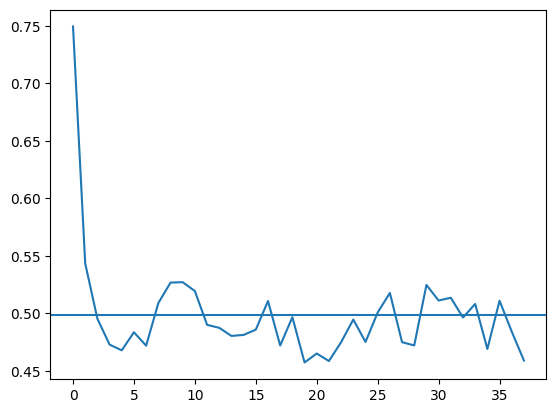

In [26]:
import matplotlib.pyplot as plt

plt.plot(mean_time[1])
plt.axhline(mean_time[0])